<img src="../IMG/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">

<br><br><br>
<h2><font color="#00586D" size=4>Trabajo Fin de Máster</font></h2>

<h1><font color="#00586D" size=5>Análisis y Predicción de Resultados en Partidas de Clash Royale:<br><b>5. Modelado</b></font></h1>
<br><br><br>


<div align="right">
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font><br>
</div>

<font color="#00586D" size=3>Iván Fernández García</font><br>
<font color="#00586D" size=3>Curso académico 2024/2025</font><br>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
* [2. Baselines](#section2)
* [3. Validación y selección de modelos: Optimización de hiperparámetros](#section3)
    * [3.1. Regresión logística y Regresión Ridge](#section3_1)
    * [3.2. Árboles de decisión](#section3_2)
    * [3.3. K-Nearest Neighbors (KNN)](#section3_3)
    * [3.4. Bagging y Random Forest](#section3_4)
    * [3.5. Boosting](#section3_5)
* [4. Evaluación final de modelos](#section4)
* [5. Conclusiones](#section5)

---

In [2]:
import sys
import os
import warnings
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [3]:
set_config(transform_output="pandas")
warnings.filterwarnings("ignore")

---

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>

Durante la fase de modelado, por fin entrenaremos diferentes modelos de aprendizaje automático. Concretamente, probaremos diferentes algoritmos de clasificación que recibirán los datos transformados mediante los *pipelines* de preprocesamiento implementados en la fase anterior. Para ello, es necesario cargarlos y también importar las funciones utilizadas en la fase de creación.

In [4]:
sys.path.append(os.path.abspath(".."))

from preprocessing_functions import (
    create_diff_starting_trophies, create_diff_mean_card_level, create_diff_min_card_level, create_diff_max_card_level,
    create_diff_support_card_level, create_diff_total_star_level, create_diff_mean_elixir_cost, create_diff_num_evolution_cards,
    create_diff_num_win_condition_cards, create_diff_num_melee_cards, create_diff_num_ranged_cards, create_diff_num_air_cards,
    create_diff_num_anti_air_cards, create_diff_num_direct_damage_cards, create_diff_num_splash_damage_cards, create_diff_num_reset_attack_cards,
    create_diff_num_common_cards, create_diff_num_rare_cards, create_diff_num_epic_cards, create_diff_num_legendary_cards,
    create_diff_num_champion_cards, create_diff_num_troop_cards, create_diff_num_building_cards, create_diff_num_spell_cards,
    create_diff_num_counters, create_diff_num_uncountered_cards, create_win_condition_advantage, create_rarity_score, create_balance_score
)

preprocessing_bin_num = joblib.load("../pipelines/preprocessing/preprocessing_bin_num.joblib")
preprocessing_bin_diff = joblib.load("../pipelines/preprocessing/preprocessing_bin_diff.joblib")
preprocessing_bin_num_diff = joblib.load("../pipelines/preprocessing/preprocessing_bin_num_diff.joblib")
preprocessing_only_diff = joblib.load("../pipelines/preprocessing/preprocessing_only_diff.joblib")
preprocessing_selected_diff = joblib.load("../pipelines/preprocessing/preprocessing_selected_diff.joblib")

La metodología será la siguiente:

* En primer lugar, por cada *pipeline de preprocesamiento* se creará un modelo extremadamente sencillo que nos sirva como *baseline* para comparar los resultados.
* Se seleccionarán diferentes algoritmos de aprendizaje (Regresión logística, Random forest...) que se probarán con cada uno de los cinco *pipelines de preprocesamiento*.
* Para cada par *algoritmo-pipeline*, se optimizarán los hiperparámetros mediante una `5-CV` y se utilizará la mejor configuración para entrenar un modelo con todos los datos de entrenamiento. Debido a la gran cantidad de combinaciones que queremos probar (tanto pares *algoritmo-pipeline* como configuraciones de hiperparámetros por cada par), se ha optado por un tipo de validación que nos permita obtener una buena configuración sin requerir un tiempo de ejecución excesivo.
* Se evaluará el rendimiento de los *baselines* y de los modelos seleccionados sobre entrenamiento, validación y prueba. Para obtener un rendimiento aún más honesto, en lugar de utilizar el rendimiento obtenido con la `5-CV` durante la optimización de hiperparámetros para validar, utilizaremos una `10x5-CV` como alternativa más robusta. Esto nos permite evaluar de manera más precisa el rendimiento real de nuestros modelos, seleccionando los más eficientes y comprobando también que el rendimiento sobre el conjunto de prueba se mantiene. Esta también se aplicará a los *baselines*.

Vamos a cargar nuestro conjunto de entrenamiento. Reservaremos el de prueba para la evaluación final.

In [5]:
target = "winner"
class_names = ["player1", "player2"]
df_train = pd.read_csv("../data/final/train.csv", parse_dates=["battleTime"])
X_train, y_train = df_train.drop(columns=target), df_train[target]

Iremos almacenando los modelos en un diccionario `models`. Concretamente, incluiremos los *baselines* y la mejor configuración para cada algoritmo y *pipeline* de preprocesamiento.

In [6]:
models = {}

También definimos una semilla para que los resultados sean reproducibles:

In [7]:
random_state = 42

---

<a id="section2"></a>
## <font color="#00586D"> 2. Baselines</font>

Para comenzar, vamos a crear los modelos sencillos que nos servirán como base para comparar los resultados y analizar de manera crítica el rendimiento de clasificadores más complejos. Una opción habitual para llevar a cabo esta tarea es utilizar el algoritmo *ZeroR*, que clasifica siempre como la clase mayoritaria en el conjunto de entrenamiento. Sin embargo, iremos un paso más adelante y para cada *pipeline* de proprocesamiento entrenaremos un árbol de profundidad 1 que solamente divida por la variable y el umbral que más ganancia de información aporten. Es decir, nuestros modelos más básicos clasificarán utilizando únicamente el criterio que consideren más importante.

Para ello, creamos un *pipeline* que contiene a su vez un *pipeline* de preprocesamiento y posteriormente un clasificador, en este caso un `DecisionTreeClassifier` con profundidad 1 y el resto de parámetros por defecto. También podemos mostrar el árbol de decisión resultante con `plot_tree`.

*Nota: Debido a problemas para obtener los nombres de las columas de salida mediante `get_features_names_out` por el uso de `FunctionTransformer`, para acceder a ellos se ha utilizado el método `fit_transform`. En ningún momento se han modificado los datos, se ha accedido a las columnas de los datos transformados que el algoritmo ha utilizado como entrada solo para ver qué variable se utiliza en los árboles en lugar de un entero representando el índice de la columna.*

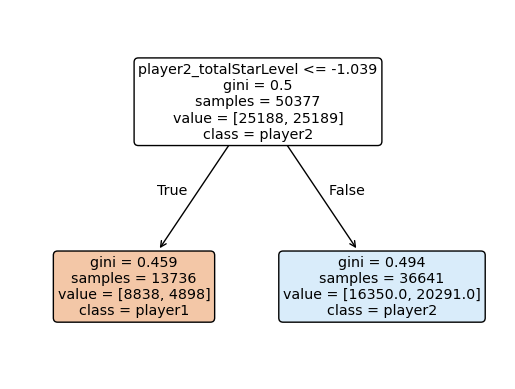

In [8]:
baseline = DecisionTreeClassifier(max_depth=1, random_state=random_state)

baseline_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", baseline)
]).fit(X_train, y_train)

models["Baseline (Binary + Numeric)"] = baseline_bin_num
plot_tree(baseline_bin_num["estimator"], filled=True, rounded=True, feature_names=preprocessing_bin_num.fit_transform(X_train).columns, class_names=class_names);

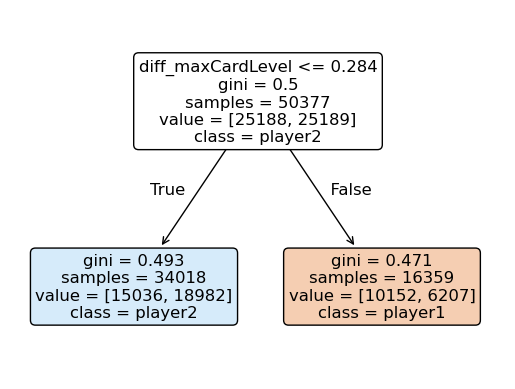

In [9]:
baseline = DecisionTreeClassifier(max_depth=1, random_state=random_state)

baseline_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", baseline)
]).fit(X_train, y_train)

models["Baseline (Binary + Differences)"] = baseline_bin_diff
plot_tree(baseline_bin_diff["estimator"], filled=True, rounded=True, feature_names=preprocessing_bin_diff.fit_transform(X_train).columns, class_names=class_names);

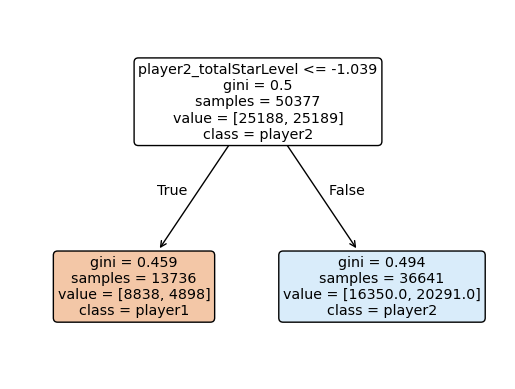

In [10]:
baseline = DecisionTreeClassifier(max_depth=1, random_state=random_state)

baseline_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", baseline)
]).fit(X_train, y_train)

models["Baseline (Binary + Numeric + Differences)"] = baseline_bin_num_diff
plot_tree(baseline_bin_num_diff["estimator"], filled=True, rounded=True, feature_names=preprocessing_bin_num_diff.fit_transform(X_train).columns, class_names=class_names);

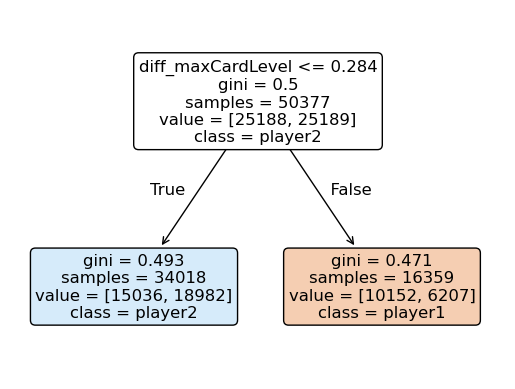

In [11]:
baseline = DecisionTreeClassifier(max_depth=1, random_state=random_state)

baseline_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", baseline)
]).fit(X_train, y_train)

models["Baseline (Only Differences)"] = baseline_only_diff
plot_tree(baseline_only_diff["estimator"], filled=True, rounded=True, feature_names=preprocessing_only_diff.fit_transform(X_train).columns, class_names=class_names);

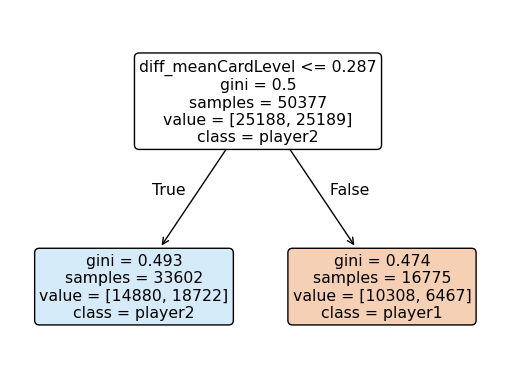

In [12]:
baseline = DecisionTreeClassifier(max_depth=1, random_state=random_state)

baseline_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", baseline)
]).fit(X_train, y_train)

models["Baseline (Selected Differences)"] = baseline_selected_diff
plot_tree(baseline_selected_diff["estimator"], filled=True, rounded=True, feature_names=preprocessing_selected_diff.fit_transform(X_train).columns, class_names=class_names);

Podemos ver que para todos los *pipelines* de preprocesamiento, las variables que más ganancia de información aportan tienen que ver con los niveles, tanto los de las cartas como los estelares.

Como ya se ha explicado anteriormente, se utilizarán estos clasificadores como base para evaluar la mejora en los modelos de los diferentes *pipelines* de preprocesamiento.

---

<a id="section3"></a>
## <font color="#00586D"> 3. Validación y selección de modelos: Optimización de hiperparámetros</font>

Para probar una gran cantidad de modelos y quedarnos con los mejores, utilizaremos diferentes algoritmos de aprendizaje con cada uno de los *pipelines* de preprocesamiento. Además, para cada una de estas combinaciones, utilizaremos `GridSearchCV` para probar diferentes configuraciones de hiperparámetros y quedarnos con la que mejor rendimiento ofrezca. Esto también nos permite introducir modificaciones en los pasos del preprocesamiento, pero en este caso nos enfocaremos únicamente en los del clasificador. Se ha considerado que para nuestro problema lo mejor es optimizar el *accuracy*, ya que el objetivo es acertar el mayor número de casos sin importar la clase.

Como vamos a probar tantas combinaciones y el número de configuraciones crece rápidamente conforme añadimos parámetros, para realizar las búsquedas utilizaremos una `5-CV`. Esto es suficiente para obtener una buena configuración por cada par *algoritmo-pipeline*, que durante la evaluación final se volverá a validar con una `10x5-CV` para obtener una métrica aún más honesta.

Para evitar tener que escribir prácticamente el mismo código cada vez que entrenemos, se han definido las siguientes funciones:

In [13]:
def grid_search_cv_results(grid_search):
    cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)
    return cv_results[[col for col in cv_results.columns if col.startswith("param_")] + ["mean_fit_time", "mean_test_score", "rank_test_score"]]

def do_grid_search_cv(pipeline, param_grid, X_train, y_train):
    grid_search = GridSearchCV(pipeline, param_grid, scoring="accuracy", cv=5, refit=True, n_jobs=-1, verbose=1).fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search_cv_results(grid_search)

<a id="section3_1"></a>
### <font color="#00586D"> 3.1. Regresión logística y Regresión Ridge</font>

Vamos a probar primero con un par de modelos lineales.

##### `LogisticRegression`

Para regresión logística, probaremos diferentes combinaciones de hiperparámetros incluyendo distintos valores para *C*.

In [14]:
lr = LogisticRegression(max_iter=100, random_state=random_state)

param_grid = {
    "estimator__C": [0.001, 0.01, 0.1, 1],
    "estimator__solver": ["liblinear", "saga"],
    "estimator__tol": [1e-4, 1e-2]
}

Esta misma rejilla se utilizará con todos los *pipelines* de preprocesamiento. La salida es el modelo con la mejor configuración reentrenado con todos los datos de entrenamiento y los resultados de la validación cruzada.

In [15]:
lr_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", lr)
])

best_estimator, cv_results = do_grid_search_cv(lr_bin_num, param_grid, X_train, y_train)
models["Logistic Regression (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_estimator__C,param_estimator__solver,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
5,0.01,liblinear,0.0100,7.324798,0.622050,1
6,0.01,saga,0.0001,8.221431,0.622030,2
4,0.01,liblinear,0.0001,10.850098,0.622010,3
7,0.01,saga,0.0100,4.902418,0.621970,4
9,0.10,liblinear,0.0100,8.054408,0.621553,5
11,0.10,saga,0.0100,5.340384,0.621514,6
10,0.10,saga,0.0001,13.969071,0.621474,7
8,0.10,liblinear,0.0001,13.778798,0.621474,7
15,1.00,saga,0.0100,5.132782,0.621434,9
12,1.00,liblinear,0.0001,14.776093,0.621434,10


In [16]:
lr_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", lr)
])

best_estimator, cv_results = do_grid_search_cv(lr_bin_diff, param_grid, X_train, y_train)
models["Logistic Regression (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_estimator__C,param_estimator__solver,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
5,0.01,liblinear,0.0100,5.555011,0.617464,1
4,0.01,liblinear,0.0001,6.330334,0.617385,2
7,0.01,saga,0.0100,4.675406,0.617385,3
6,0.01,saga,0.0001,8.862995,0.617365,4
11,0.10,saga,0.0100,7.182875,0.616809,5
8,0.10,liblinear,0.0001,7.985005,0.616710,6
10,0.10,saga,0.0001,18.503062,0.616710,7
15,1.00,saga,0.0100,6.984183,0.616551,8
12,1.00,liblinear,0.0001,7.557470,0.616333,9
9,0.10,liblinear,0.0100,5.908801,0.616313,10


In [17]:
lr_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", lr)
])

best_estimator, cv_results = do_grid_search_cv(lr_bin_num_diff, param_grid, X_train, y_train)
models["Logistic Regression (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_estimator__C,param_estimator__solver,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
7,0.01,saga,0.0100,5.439594,0.622764,1
5,0.01,liblinear,0.0100,8.470191,0.622744,2
6,0.01,saga,0.0001,12.305193,0.622605,3
4,0.01,liblinear,0.0001,11.378000,0.622566,4
10,0.10,saga,0.0001,24.201996,0.621871,5
8,0.10,liblinear,0.0001,15.197198,0.621792,6
11,0.10,saga,0.0100,8.589789,0.621772,7
9,0.10,liblinear,0.0100,8.479408,0.621593,8
13,1.00,liblinear,0.0100,9.153259,0.621534,9
15,1.00,saga,0.0100,8.192577,0.621534,10


In [18]:
lr_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", lr)
])

best_estimator, cv_results = do_grid_search_cv(lr_only_diff, param_grid, X_train, y_train)
models["Logistic Regression (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_estimator__C,param_estimator__solver,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
5,0.01,liblinear,0.0100,2.354194,0.607202,1
7,0.01,saga,0.0100,1.845596,0.607102,2
6,0.01,saga,0.0001,2.379798,0.607063,3
4,0.01,liblinear,0.0001,2.872404,0.607043,4
9,0.10,liblinear,0.0100,2.305604,0.606944,5
12,1.00,liblinear,0.0001,2.845005,0.606904,6
14,1.00,saga,0.0001,2.327783,0.606904,6
11,0.10,saga,0.0100,1.907202,0.606904,8
8,0.10,liblinear,0.0001,2.927409,0.606844,9
10,0.10,saga,0.0001,2.358805,0.606824,10


In [19]:
lr_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", lr)
])

best_estimator, cv_results = do_grid_search_cv(lr_selected_diff, param_grid, X_train, y_train)
models["Logistic Regression (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,param_estimator__C,param_estimator__solver,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
3,0.001,saga,0.0100,1.659603,0.600770,1
2,0.001,saga,0.0001,2.225992,0.600711,2
1,0.001,liblinear,0.0100,1.901203,0.600691,3
0,0.001,liblinear,0.0001,1.672215,0.600691,4
7,0.010,saga,0.0100,1.677602,0.600333,5
5,0.010,liblinear,0.0100,1.963996,0.600314,6
12,1.000,liblinear,0.0001,2.203225,0.600294,7
9,0.100,liblinear,0.0100,1.886005,0.600294,7
8,0.100,liblinear,0.0001,2.280013,0.600274,9
14,1.000,saga,0.0001,2.091173,0.600274,10


Podemos ver que en los cinco casos el rendimiento medio de la validación es muy similar entre combinaciones. Entre *pipelines* sí vemos más diferencia, ya que aquellos que conservan más características parecen funcionar algo mejor. Respecto al rendimiento, no es especialmente alto. Veremos cómo de grande es el margen de mejora cuando entrenemos modelos más complejos.

##### `RidgeClassifier`

*Scikit-learn* implementa un clasificador que utiliza regresión *Ridge* sustituyendo el valor de las clases por -1 y 1. Vamos a probar diferentes configuraciones.

In [20]:
ridge = RidgeClassifier(random_state=random_state)

param_grid = {
    "estimator__alpha": [0.01, 0.1, 1, 10, 100, 1000],
    "estimator__tol": [1e-4, 1e-2]
}

In [21]:
ridge_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", ridge)
])

best_estimator, cv_results = do_grid_search_cv(ridge_bin_num, param_grid, X_train, y_train)
models["Ridge Classifier (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_estimator__alpha,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
6,10.00,0.0001,5.031642,0.621514,1
7,10.00,0.0100,5.260626,0.621514,1
0,0.01,0.0001,5.009002,0.621454,3
1,0.01,0.0100,5.826607,0.621454,3
3,0.10,0.0100,5.239133,0.621414,5
2,0.10,0.0001,4.885202,0.621414,5
5,1.00,0.0100,4.971933,0.621315,7
4,1.00,0.0001,5.417416,0.621315,7
8,100.00,0.0001,5.224377,0.621295,9
9,100.00,0.0100,5.106338,0.621295,9


In [22]:
ridge_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", ridge)
])

best_estimator, cv_results = do_grid_search_cv(ridge_bin_diff, param_grid, X_train, y_train)
models["Ridge Classifier (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_estimator__alpha,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
11,1000.0,0.0100,3.592781,0.617623,1
10,1000.0,0.0001,4.406385,0.617623,1
9,100.0,0.0100,4.717613,0.617008,3
8,100.0,0.0001,4.526768,0.617008,3
6,10.0,0.0001,4.785813,0.616531,5
7,10.0,0.0100,4.585524,0.616531,5
2,0.1,0.0001,4.395407,0.616273,7
3,0.1,0.0100,4.863996,0.616273,7
4,1.0,0.0001,4.684792,0.616273,9
5,1.0,0.0100,4.751352,0.616273,9


In [23]:
ridge_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", ridge)
])

best_estimator, cv_results = do_grid_search_cv(ridge_bin_num_diff, param_grid, X_train, y_train)
models["Ridge Classifier (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_estimator__alpha,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
11,1000.00,0.0100,4.254178,0.623062,1
10,1000.00,0.0001,5.267390,0.623062,1
9,100.00,0.0100,5.778405,0.621950,3
8,100.00,0.0001,5.554993,0.621950,3
1,0.01,0.0100,5.784665,0.621454,5
0,0.01,0.0001,4.799122,0.621454,5
6,10.00,0.0001,5.786002,0.621434,7
7,10.00,0.0100,5.291407,0.621434,7
3,0.10,0.0100,5.785403,0.621414,9
2,0.10,0.0001,5.597985,0.621414,9


In [24]:
ridge_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", ridge)
])

best_estimator, cv_results = do_grid_search_cv(ridge_only_diff, param_grid, X_train, y_train)
models["Ridge Classifier (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_estimator__alpha,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
8,100.00,0.0001,1.581596,0.607102,1
9,100.00,0.0100,1.584597,0.607102,1
10,1000.00,0.0001,1.545185,0.607063,3
11,1000.00,0.0100,1.200184,0.607063,3
3,0.10,0.0100,1.455611,0.607023,5
2,0.10,0.0001,1.466597,0.607023,5
1,0.01,0.0100,1.631993,0.607023,5
0,0.01,0.0001,1.584417,0.607023,5
5,1.00,0.0100,1.665808,0.607023,5
4,1.00,0.0001,1.520595,0.607023,5


In [25]:
ridge_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", ridge)
])

best_estimator, cv_results = do_grid_search_cv(ridge_selected_diff, param_grid, X_train, y_train)
models["Ridge Classifier (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_estimator__alpha,param_estimator__tol,mean_fit_time,mean_test_score,rank_test_score
11,1000.00,0.0100,1.055177,0.600750,1
10,1000.00,0.0001,1.349999,0.600750,1
9,100.00,0.0100,1.401409,0.599996,3
8,100.00,0.0001,1.365407,0.599996,3
3,0.10,0.0100,1.283797,0.599857,5
2,0.10,0.0001,1.265214,0.599857,5
1,0.01,0.0100,1.235397,0.599857,5
0,0.01,0.0001,0.952811,0.599857,5
7,10.00,0.0100,1.295193,0.599857,5
6,10.00,0.0001,1.229206,0.599857,5


Los resultados son bastante similares a los obtenidos con la regresión logística.

<a id="section3_2"></a>
### <font color="#00586D"> 3.2. Árboles de decisión</font>

Vamos a utilizar ahora árboles de decisión (`DecisionTreeClassifier`). Estos modelos son más complejos y por lo general sobreajustan mucho más que los anteriores. Probaremos varias configuraciones modificando hiperámetros como la profundidad o el criterio de partición.

In [26]:
tree = DecisionTreeClassifier(random_state=random_state)

param_grid = {
    "estimator__criterion": ["gini", "entropy"],
    "estimator__max_depth": [5, 10, None],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4]
}

In [27]:
tree_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", tree)
])

best_estimator, cv_results = do_grid_search_cv(tree_bin_num, param_grid, X_train, y_train)
models["Decision Tree (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,mean_fit_time,mean_test_score,rank_test_score
32,entropy,5,2,10,5.442601,0.601564,1
33,entropy,5,4,2,5.258604,0.601564,1
34,entropy,5,4,5,5.323603,0.601564,1
27,entropy,5,1,2,4.381822,0.601564,1
29,entropy,5,1,10,5.356000,0.601564,1
28,entropy,5,1,5,4.881543,0.601564,1
30,entropy,5,2,2,5.397002,0.601564,1
31,entropy,5,2,5,5.319009,0.601564,1
35,entropy,5,4,10,5.152196,0.601564,1
8,gini,5,4,10,5.472184,0.601386,10


In [28]:
tree_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", tree)
])

best_estimator, cv_results = do_grid_search_cv(tree_bin_diff, param_grid, X_train, y_train)
models["Decision Tree (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,mean_fit_time,mean_test_score,rank_test_score
0,gini,5,1,2,4.419417,0.595669,1
1,gini,5,1,5,4.660999,0.595669,1
2,gini,5,1,10,4.993001,0.595669,1
3,gini,5,2,2,5.265202,0.595669,1
4,gini,5,2,5,4.515386,0.595669,1
5,gini,5,2,10,5.132993,0.595669,1
6,gini,5,4,2,5.169007,0.595649,7
7,gini,5,4,5,5.024594,0.595649,7
8,gini,5,4,10,4.893604,0.595649,7
31,entropy,5,2,5,4.747801,0.595153,10


In [29]:
tree_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", tree)
])

best_estimator, cv_results = do_grid_search_cv(tree_bin_num_diff, param_grid, X_train, y_train)
models["Decision Tree (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,mean_fit_time,mean_test_score,rank_test_score
0,gini,5,1,2,5.919412,0.610537,1
1,gini,5,1,5,6.650000,0.610537,1
2,gini,5,1,10,5.905800,0.610537,1
3,gini,5,2,2,6.236197,0.610537,1
4,gini,5,2,5,5.737608,0.610537,1
5,gini,5,2,10,5.973000,0.610537,1
6,gini,5,4,2,6.063396,0.610537,1
7,gini,5,4,5,5.827597,0.610537,1
8,gini,5,4,10,6.000588,0.610537,1
33,entropy,5,4,2,6.016792,0.609524,10


In [30]:
tree_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", tree)
])

best_estimator, cv_results = do_grid_search_cv(tree_only_diff, param_grid, X_train, y_train)
models["Decision Tree (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,mean_fit_time,mean_test_score,rank_test_score
0,gini,5,1,2,1.471002,0.595808,1
1,gini,5,1,5,1.604806,0.595808,1
2,gini,5,1,10,1.738204,0.595808,1
3,gini,5,2,2,1.719436,0.595808,1
4,gini,5,2,5,1.671044,0.595808,1
5,gini,5,2,10,1.727614,0.595808,1
6,gini,5,4,2,1.729205,0.595808,1
7,gini,5,4,5,1.773009,0.595808,1
8,gini,5,4,10,1.722387,0.595808,1
34,entropy,5,4,5,1.754799,0.595708,10


In [31]:
tree_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", tree)
])

best_estimator, cv_results = do_grid_search_cv(tree_selected_diff, param_grid, X_train, y_train)
models["Decision Tree (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,mean_fit_time,mean_test_score,rank_test_score
32,entropy,5,2,10,1.392204,0.589039,1
31,entropy,5,2,5,1.362404,0.589039,1
30,entropy,5,2,2,1.375800,0.589039,1
27,entropy,5,1,2,1.469035,0.589039,1
29,entropy,5,1,10,1.411276,0.589039,1
28,entropy,5,1,5,1.463986,0.589039,1
34,entropy,5,4,5,1.390192,0.589019,7
33,entropy,5,4,2,1.370201,0.589019,7
35,entropy,5,4,10,1.321398,0.589019,7
0,gini,5,1,2,1.076799,0.588979,10


Aquí también observamos lo mismo respecto a preprocesamiento y configuraciones, aunque sorprendentemente el rendimiento es peor que en los casos anteriores. Los mejores modelos sobre validación suelen obtenerse mediante árboles que no se expanden hasta el final porque sobreajustan en exceso, aunque es llamativo que en este caso los mejores árboles sean tan poco profundos.

<a id="section3_3"></a>
### <font color="#00586D"> 3.3. K-Nearest Neighbors (KNN)</font>

En la fase anterior, se decidió estandarizar los datos en todos los *pipelines* de preprocesamiento principalmente para probar este algoritmo con las variables en la misma escala y conseguir así un mejor rendimiento. Vamos a probar diferentes valores para los vecinos, algunos extremadamente grandes.

In [32]:
knn = KNeighborsClassifier()

param_grid = {
    "estimator__n_neighbors": [1, 5, 10, 25, 50, 100, 250, 500, 1000, 2500],
    "estimator__weights": ["uniform", "distance"]
}

In [33]:
knn_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", knn)
])

best_estimator, cv_results = do_grid_search_cv(knn_bin_num, param_grid, X_train, y_train)
models["KNN (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_estimator__n_neighbors,param_estimator__weights,mean_fit_time,mean_test_score,rank_test_score
13,250,distance,4.041803,0.576414,1
11,100,distance,4.370191,0.575342,2
15,500,distance,4.121397,0.575163,3
12,250,uniform,3.998005,0.574905,4
14,500,uniform,4.161625,0.574845,5
9,50,distance,4.126272,0.573972,6
10,100,uniform,3.685667,0.573456,7
17,1000,distance,4.524396,0.573039,8
16,1000,uniform,4.459218,0.572900,9
8,50,uniform,3.915004,0.570478,10


In [34]:
knn_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", knn)
])

best_estimator, cv_results = do_grid_search_cv(knn_bin_diff, param_grid, X_train, y_train)
models["KNN (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_estimator__n_neighbors,param_estimator__weights,mean_fit_time,mean_test_score,rank_test_score
19,2500,distance,4.686394,0.612025,1
18,2500,uniform,5.358401,0.611311,2
16,1000,uniform,4.656189,0.610715,3
17,1000,distance,4.564000,0.610636,4
15,500,distance,4.325902,0.609822,5
14,500,uniform,4.405007,0.609643,6
13,250,distance,3.979403,0.605911,7
12,250,uniform,3.958189,0.605276,8
11,100,distance,4.017942,0.600274,9
10,100,uniform,3.876274,0.599460,10


In [35]:
knn_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", knn)
])

best_estimator, cv_results = do_grid_search_cv(knn_bin_num_diff, param_grid, X_train, y_train)
models["KNN (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_estimator__n_neighbors,param_estimator__weights,mean_fit_time,mean_test_score,rank_test_score
17,1000,distance,4.995199,0.598289,1
16,1000,uniform,5.057832,0.598269,2
15,500,distance,4.909594,0.598031,3
14,500,uniform,5.048806,0.597812,4
13,250,distance,5.045000,0.597792,5
12,250,uniform,4.307990,0.597435,6
11,100,distance,4.542582,0.595232,7
10,100,uniform,4.125192,0.594358,8
18,2500,uniform,6.480614,0.593981,9
19,2500,distance,5.186194,0.593663,10


In [36]:
knn_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", knn)
])

best_estimator, cv_results = do_grid_search_cv(knn_only_diff, param_grid, X_train, y_train)
models["KNN (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_estimator__n_neighbors,param_estimator__weights,mean_fit_time,mean_test_score,rank_test_score
15,500,distance,1.703994,0.605097,1
14,500,uniform,1.620996,0.604998,2
18,2500,uniform,2.210208,0.604145,3
19,2500,distance,2.489000,0.604145,4
17,1000,distance,2.191396,0.603589,5
16,1000,uniform,1.829999,0.603430,6
13,250,distance,1.553813,0.602557,7
12,250,uniform,1.114592,0.601644,8
11,100,distance,1.276615,0.595033,9
10,100,uniform,0.903995,0.593386,10


In [37]:
knn_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", knn)
])

best_estimator, cv_results = do_grid_search_cv(knn_selected_diff, param_grid, X_train, y_train)
models["KNN (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_estimator__n_neighbors,param_estimator__weights,mean_fit_time,mean_test_score,rank_test_score
15,500,distance,1.740814,0.597396,1
16,1000,uniform,1.679000,0.597336,2
17,1000,distance,1.736000,0.597118,3
14,500,uniform,1.354388,0.596304,4
19,2500,distance,2.013996,0.596244,5
18,2500,uniform,1.872400,0.595550,6
12,250,uniform,0.991609,0.593287,7
13,250,distance,1.419601,0.592909,8
11,100,distance,1.050811,0.587808,9
10,100,uniform,1.019602,0.587728,10


En este caso sí vemos algunas diferencias en los resultados. *KNN* tiende a funcionar mal cuando la dimensionalidad es muy grande como en el primer y tercer caso, aunque es cierto que cuando el número de características se reduce tampoco observamos una gran mejora. Es muy llamativo que las mejores configuraciones utilizan un número enorme de vecinos, debido a la gran variedad de combinaciones dentro de *Clash Royale* y la dificultad para obtener un buen rendimiento recurriendo a partidas supuestamente parecidas cuando no se cuenta con una cantidad inmensa de datos. Para este problema concreto, *KNN* transmite muy poca confianza.

<a id="section3_4"></a>
### <font color="#00586D"> 3.4. Bagging y Random Forest</font>

Comenzamos con los ensembles mediante *Bagging*.

##### `BaggingClassifier`

Este ensemble no trabaja únicamente con árboles de decisión, por lo que lo probaremos también con los dos modelos lineales como base. Queremos optimizar los hiperámetros del propio ensemble, por lo que en lugar de incluir combinaciones que inclutan a su vez hiperámetros del estimador base, utilizaremos aquellos que han ofrecido un buen resultado individualmente.

In [38]:
bagging = BaggingClassifier(random_state=random_state)

param_grid = [
    {
        "estimator__estimator": [LogisticRegression(C=0.01, tol=0.01, solver="saga", random_state=random_state)],
        "estimator__n_estimators": [25, 50],
        "estimator__max_samples": [0.5, 1.0],
        "estimator__max_features": [0.5, 1.0]
    },
    {
        "estimator__estimator": [RidgeClassifier(tol=0.01, alpha=1000, random_state=random_state)],
        "estimator__n_estimators": [25, 50],
        "estimator__max_samples": [0.5, 1.0],
        "estimator__max_features": [0.5, 1.0]
    },
    {
        "estimator__estimator": [DecisionTreeClassifier(max_depth=5, random_state=random_state)],
        "estimator__n_estimators": [25, 50],
        "estimator__max_samples": [0.5, 1.0],
        "estimator__max_features": [0.5, 1.0]
    }
]

In [39]:
bagging_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", bagging)
])

best_estimator, cv_results = do_grid_search_cv(bagging_bin_num, param_grid, X_train, y_train)
models["Bagging (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,132.863465,0.622109,1
6,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,25,47.383634,0.621772,2
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,99.188518,0.621057,3
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,49.056189,0.620720,4
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,27.325799,0.620541,5
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,48.708632,0.619727,6
12,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,25,25.469208,0.619290,7
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,55.153805,0.618655,8
3,"LogisticRegression(C=0.01, random_state=42, so...",0.5,1.0,50,59.988800,0.618119,9
1,"LogisticRegression(C=0.01, random_state=42, so...",0.5,0.5,50,60.695221,0.617385,10


In [40]:
bagging_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", bagging)
])

best_bagging_bin_diff, bagging_bin_diff_results = do_grid_search_cv(bagging_bin_diff, param_grid, X_train, y_train)
models["Bagging (Binary + Differences)"] = best_bagging_bin_diff
bagging_bin_diff_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,98.769907,0.618457,1
6,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,25,48.138119,0.618298,2
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,48.769545,0.618199,3
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,40.203396,0.617941,4
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,24.024397,0.617742,5
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,138.726000,0.617484,6
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,42.990252,0.617345,7
12,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,25,19.319393,0.617047,8
3,"LogisticRegression(C=0.01, random_state=42, so...",0.5,1.0,50,62.295995,0.616531,9
1,"LogisticRegression(C=0.01, random_state=42, so...",0.5,0.5,50,61.824192,0.616313,10


In [41]:
bagging_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", bagging)
])

best_estimator, cv_results = do_grid_search_cv(bagging_num_diff, param_grid, X_train, y_train)
models["Bagging (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,99.923104,0.618457,1
6,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,25,48.667686,0.618298,2
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,48.455433,0.618199,3
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,40.156559,0.617941,4
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,23.330799,0.617742,5
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,138.039836,0.617484,6
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,44.876930,0.617345,7
12,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,25,19.323755,0.617047,8
3,"LogisticRegression(C=0.01, random_state=42, so...",0.5,1.0,50,61.879025,0.616531,9
1,"LogisticRegression(C=0.01, random_state=42, so...",0.5,0.5,50,61.556121,0.616313,10


In [42]:
bagging_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", bagging)
])

best_estimator, cv_results = do_grid_search_cv(bagging_bin_num_diff, param_grid, X_train, y_train)
models["Bagging (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,115.196431,0.623519,1
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,56.436813,0.623201,2
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,165.578669,0.623122,3
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,32.930528,0.623102,4
6,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,25,56.570386,0.623062,5
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,63.782239,0.622943,6
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,54.878805,0.622665,7
0,"LogisticRegression(C=0.01, random_state=42, so...",0.5,0.5,25,35.945805,0.622328,8
3,"LogisticRegression(C=0.01, random_state=42, so...",0.5,1.0,50,67.081211,0.622288,9
2,"LogisticRegression(C=0.01, random_state=42, so...",0.5,1.0,25,36.516232,0.622228,10


In [43]:
bagging_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", bagging)
])

best_estimator, cv_results = do_grid_search_cv(bagging_only_diff, param_grid, X_train, y_train)
models["Bagging (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
17,"DecisionTreeClassifier(max_depth=5, random_sta...",0.5,0.5,50,5.411586,0.608750,1
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,10.147986,0.607499,2
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,3.377978,0.607480,3
12,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,25,2.997390,0.607460,4
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,4.651398,0.607420,5
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,5.123403,0.607301,6
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,20.094040,0.607142,7
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,26.303609,0.607122,8
16,"DecisionTreeClassifier(max_depth=5, random_sta...",0.5,0.5,25,3.777211,0.607063,9
19,"DecisionTreeClassifier(max_depth=5, random_sta...",0.5,1.0,50,7.205792,0.607023,10


In [44]:
bagging_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", bagging)
])

best_estimator, cv_results = do_grid_search_cv(bagging_selected_diff, param_grid, X_train, y_train)
models["Bagging (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,param_estimator__estimator,param_estimator__max_features,param_estimator__max_samples,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
13,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,50,3.896821,0.601167,1
5,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,50,17.219391,0.600790,2
17,"DecisionTreeClassifier(max_depth=5, random_sta...",0.5,0.5,50,4.665007,0.600552,3
7,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,50,23.280819,0.600433,4
15,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,50,3.932395,0.600314,5
4,"LogisticRegression(C=0.01, random_state=42, so...",1.0,0.5,25,8.754593,0.600175,6
12,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,0.5,25,2.408997,0.600175,7
14,"RidgeClassifier(alpha=1000, random_state=42, t...",1.0,1.0,25,2.503797,0.600155,8
6,"LogisticRegression(C=0.01, random_state=42, so...",1.0,1.0,25,8.725194,0.600155,9
19,"DecisionTreeClassifier(max_depth=5, random_sta...",0.5,1.0,50,6.189401,0.599817,10


El rendimiento es muy similar entre configuraciones, y los resultados según el *pipeline* de preprocesamiento también es el mismo que individualmente. En ningún caso las mejores configuraciones incluyen árboles de decisión, y el hecho de combinar varios clasificadores prácticamente no mejora los resultados de las regresiones por sí mismas. Esto nos hace pensar que realmente nos encontramos ante un problema complejo.

##### `RandomForestClassifier`

*Random Forest* es una variante de *Bagging* que solamente utiliza árboles de decisión y además realiza cada partición utilizando un subconjunto de características para introducir más variedad. Todo ello lo convierte en uno de los algoritmos de aprendizaje automático más utilizados actualmente.

In [45]:
rf = RandomForestClassifier(random_state=random_state)

param_grid = {
    "estimator__n_estimators": [250, 500],
    "estimator__max_depth": [20, None],
    "estimator__min_samples_split": [2, 5, 10],
    "estimator__min_samples_leaf": [1, 2, 4],
    "estimator__criterion": ["gini", "entropy"]
}

In [46]:
rf_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", rf)
])

best_estimator, cv_results = do_grid_search_cv(rf_bin_num, param_grid, X_train, y_train)
models["Random Forest (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
65,entropy,None,2,10,500,193.142794,0.625007,1
63,entropy,None,2,5,500,202.139361,0.624233,2
23,gini,None,1,10,500,187.000597,0.623578,3
31,gini,None,4,2,500,174.195563,0.623459,4
33,gini,None,4,5,500,174.133058,0.623459,4
61,entropy,None,2,2,500,203.742849,0.623181,6
35,gini,None,4,10,500,169.377522,0.622367,7
71,entropy,None,4,10,500,114.224919,0.622347,8
59,entropy,None,1,10,500,196.878175,0.622208,9
30,gini,None,4,2,250,88.271525,0.622070,10


In [47]:
rf_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", rf)
])

best_estimator, cv_results = do_grid_search_cv(rf_bin_diff, param_grid, X_train, y_train)
models["Random Forest (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
65,entropy,None,2,10,500,193.184733,0.626020,1
29,gini,None,2,10,500,181.613104,0.625742,2
71,entropy,None,4,10,500,103.289621,0.625226,3
37,entropy,20,1,2,500,154.846327,0.625127,4
63,entropy,None,2,5,500,203.246783,0.625107,5
61,entropy,None,2,2,500,199.766504,0.625087,6
57,entropy,None,1,5,500,207.325567,0.625047,7
68,entropy,None,4,5,250,90.052173,0.624908,8
66,entropy,None,4,2,250,89.950918,0.624908,8
31,gini,None,4,2,500,172.063500,0.624868,10


In [48]:
rf_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", rf)
])

best_estimator, cv_results = do_grid_search_cv(rf_bin_num_diff, param_grid, X_train, y_train)
models["Random Forest (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
59,entropy,None,1,10,500,204.386549,0.631161,1
29,gini,None,2,10,500,189.470312,0.630883,2
45,entropy,20,2,5,500,175.506600,0.630744,3
10,gini,20,2,10,250,83.960592,0.630744,4
5,gini,20,1,10,500,169.778731,0.630585,5
25,gini,None,2,2,500,199.221767,0.630486,6
6,gini,20,2,2,250,88.425603,0.630486,7
44,entropy,20,2,5,250,87.409583,0.630367,8
7,gini,20,2,2,500,174.157585,0.630288,9
41,entropy,20,1,10,500,172.088004,0.630228,10


In [49]:
rf_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", rf)
])

best_estimator, cv_results = do_grid_search_cv(rf_only_diff, param_grid, X_train, y_train)
models["Random Forest (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
43,entropy,20,2,2,500,59.407162,0.614943,1
5,gini,20,1,10,500,54.966318,0.614229,2
48,entropy,20,4,2,250,28.358874,0.614110,3
50,entropy,20,4,5,250,28.267548,0.614110,3
41,entropy,20,1,10,500,58.211200,0.613931,5
49,entropy,20,4,2,500,56.408280,0.613891,6
51,entropy,20,4,5,500,55.630847,0.613891,6
40,entropy,20,1,10,250,29.459020,0.613792,8
17,gini,20,4,10,500,51.339535,0.613772,9
63,entropy,None,2,5,500,68.777529,0.613673,10


In [50]:
rf_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", rf)
])

best_estimator, cv_results = do_grid_search_cv(rf_selected_diff, param_grid, X_train, y_train)
models["Random Forest (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


,param_estimator__criterion,param_estimator__max_depth,param_estimator__min_samples_leaf,param_estimator__min_samples_split,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
65,entropy,None,2,10,500,56.588449,0.608949,1
5,gini,20,1,10,500,47.114925,0.608413,2
51,entropy,20,4,5,500,48.087651,0.608214,3
49,entropy,20,4,2,500,48.993947,0.608214,3
15,gini,20,4,5,500,45.316005,0.607877,5
13,gini,20,4,2,500,45.473459,0.607877,5
47,entropy,20,2,10,500,49.374160,0.607837,7
45,entropy,20,2,5,500,52.128422,0.607757,8
37,entropy,20,1,2,500,53.991983,0.607698,9
43,entropy,20,2,2,500,51.845864,0.607539,10


El rendimiento entre *pipelines* de preprocesamiento se mantiene, aunque sí observamos una mejora respecto a los árboles individuales. Sin embargo, es cierto que para ser un clasificador tan robusto, el rendimiento no es especialmente alto.

<a id="section3_5"></a>
### <font color="#00586D"> 3.5. Boosting</font>

Por último, probaremos otro tipo de ensembles.

##### `AdaBoostClassifier`

Para *Adaptive Boosting* probaremos con distintas tasas de aprendizaje y varias profundidades para el estimador base:

In [51]:
ab = AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=random_state),random_state=random_state)

param_grid = {
    "estimator__estimator__max_depth": [1, 2, 3, 10],
    "estimator__n_estimators": [100, 200],
    "estimator__learning_rate": [0.01, 0.1, 0.5, 1.0]
}

In [52]:
ab_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", ab)
])

best_estimator, cv_results = do_grid_search_cv(ab_bin_num, param_grid, X_train, y_train)
models["AdaBoost (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_estimator__estimator__max_depth,param_estimator__learning_rate,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
27,10,0.10,200,561.216946,0.625762,1
26,10,0.10,100,320.109250,0.625404,2
21,3,0.50,200,200.097951,0.622486,3
25,10,0.01,200,749.936376,0.621474,4
20,3,0.50,100,101.908014,0.620918,5
23,3,1.00,200,199.755790,0.620164,6
15,2,1.00,200,149.289193,0.619965,7
24,10,0.01,100,400.830517,0.618159,8
14,2,1.00,100,79.255506,0.617682,9
19,3,0.10,200,203.398302,0.617663,10


In [53]:
ab_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", ab)
])

best_estimator, cv_results = do_grid_search_cv(ab_bin_diff, param_grid, X_train, y_train)
models["AdaBoost (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_estimator__estimator__max_depth,param_estimator__learning_rate,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
27,10,0.10,200,472.868443,0.622288,1
26,10,0.10,100,256.805361,0.621315,2
21,3,0.50,200,169.108149,0.614090,3
23,3,1.00,200,165.654301,0.613713,4
15,2,1.00,200,127.914264,0.612978,5
25,10,0.01,200,611.703397,0.612879,6
20,3,0.50,100,84.145999,0.612819,7
22,3,1.00,100,85.229940,0.611966,8
29,10,0.50,200,419.271614,0.611271,9
14,2,1.00,100,68.354756,0.610834,10


In [54]:
ab_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", ab)
])

best_estimator, cv_results = do_grid_search_cv(ab_bin_num_diff, param_grid, X_train, y_train)
models["AdaBoost (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_estimator__estimator__max_depth,param_estimator__learning_rate,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
27,10,0.10,200,661.186560,0.627350,1
26,10,0.10,100,354.502855,0.626794,2
25,10,0.01,200,820.921373,0.625444,3
22,3,1.00,100,120.065231,0.623360,4
23,3,1.00,200,233.467826,0.623221,5
15,2,1.00,200,179.218678,0.623002,6
21,3,0.50,200,234.327702,0.622685,7
24,10,0.01,100,431.975981,0.621772,8
20,3,0.50,100,120.377154,0.621772,9
14,2,1.00,100,94.076882,0.621256,10


In [55]:
ab_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", ab)
])

best_estimator, cv_results = do_grid_search_cv(ab_only_diff, param_grid, X_train, y_train)
models["AdaBoost (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_estimator__estimator__max_depth,param_estimator__learning_rate,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
27,10,0.10,200,102.251854,0.611628,1
26,10,0.10,100,48.836509,0.610219,2
22,3,1.00,100,20.048746,0.608075,3
23,3,1.00,200,39.294350,0.607996,4
25,10,0.01,200,99.669325,0.606110,5
21,3,0.50,200,39.744420,0.606070,6
20,3,0.50,100,20.094339,0.606031,7
15,2,1.00,200,31.221246,0.605931,8
13,2,0.50,200,31.627594,0.604959,9
14,2,1.00,100,15.893200,0.604800,10


In [56]:
ab_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", ab)
])

best_estimator, cv_results = do_grid_search_cv(ab_selected_diff, param_grid, X_train, y_train)
models["AdaBoost (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


,param_estimator__estimator__max_depth,param_estimator__learning_rate,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
27,10,0.10,200,80.110232,0.604184,1
26,10,0.10,100,40.013553,0.603529,2
25,10,0.01,200,81.207625,0.601703,3
23,3,1.00,200,33.549694,0.600949,4
15,2,1.00,200,27.554631,0.600492,5
19,3,0.10,200,33.609482,0.600095,6
22,3,1.00,100,17.002614,0.599897,7
24,10,0.01,100,40.579677,0.599738,8
21,3,0.50,200,33.355818,0.599222,9
14,2,1.00,100,13.809595,0.599202,10


El resultado es similar al obtenido con *Random Forest*. Vemos que, a pesar de ser un algoritmo pensado para trabajar con árboles muy poco profundos, funciona algo mejor cuando aumentamos el nivel de profundidad.

##### `GradientBoostingClassifier`

Vamos a probar configuraciones similares al caso anterior.

In [57]:
gb = GradientBoostingClassifier(random_state=random_state)

param_grid = {
    "estimator__n_estimators": [100, 200],
    "estimator__learning_rate": [0.01, 0.1, 0.5],
    "estimator__max_depth": [3, 5, 10]
}

In [58]:
gb_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", gb)
])

best_estimator, cv_results = do_grid_search_cv(gb_bin_num, param_grid, X_train, y_train)
models["Gradient Boosting (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
9,0.10,5,200,214.556019,0.628779,1
8,0.10,5,100,132.082893,0.628263,2
7,0.10,3,200,140.458189,0.627906,3
6,0.10,3,100,75.685461,0.623340,4
12,0.50,3,100,68.756737,0.622526,5
5,0.01,10,200,634.777347,0.621295,6
13,0.50,3,200,132.914560,0.621077,7
3,0.01,5,200,289.280512,0.616452,8
4,0.01,10,100,352.032007,0.616035,9
11,0.10,10,200,555.332003,0.615618,10


In [59]:
gb_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", gb)
])

best_estimator, cv_results = do_grid_search_cv(gb_bin_diff, param_grid, X_train, y_train)
models["Gradient Boosting (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
9,0.10,5,200,202.801862,0.622645,1
8,0.10,5,100,106.981038,0.621295,2
7,0.10,3,200,114.628256,0.620958,3
6,0.10,3,100,61.915353,0.616631,4
12,0.50,3,100,55.969643,0.616373,5
5,0.01,10,200,597.961856,0.614387,6
13,0.50,3,200,108.070802,0.613355,7
3,0.01,5,200,244.205103,0.612601,8
10,0.10,10,100,245.052734,0.611767,9
11,0.10,10,200,452.037606,0.611132,10


In [60]:
gb_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", gb)
])

best_estimator, cv_results = do_grid_search_cv(gb_bin_num_diff, param_grid, X_train, y_train)
models["Gradient Boosting (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
7,0.10,3,200,163.611062,0.629910,1
9,0.10,5,200,282.490675,0.629156,2
8,0.10,5,100,149.866684,0.628521,3
6,0.10,3,100,86.992566,0.625821,4
12,0.50,3,100,77.447811,0.625206,5
5,0.01,10,200,759.424644,0.623558,6
3,0.01,5,200,335.632418,0.622447,7
4,0.01,10,100,393.109662,0.621355,8
13,0.50,3,200,153.457025,0.620740,9
10,0.10,10,100,293.084628,0.620680,10


In [61]:
gb_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", gb)
])

best_estimator, cv_results = do_grid_search_cv(gb_only_diff, param_grid, X_train, y_train)
models["Gradient Boosting (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
7,0.10,3,200,28.436199,0.612680,1
8,0.10,5,100,24.298396,0.611986,2
9,0.10,5,200,46.152197,0.611926,3
6,0.10,3,100,14.840806,0.611450,4
12,0.50,3,100,14.994198,0.609723,5
5,0.01,10,200,107.282597,0.607718,6
3,0.01,5,200,47.690803,0.606527,7
13,0.50,3,200,29.560002,0.605693,8
1,0.01,3,200,30.757788,0.604006,9
10,0.10,10,100,51.090199,0.603827,10


In [62]:
gb_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", gb)
])

best_estimator, cv_results = do_grid_search_cv(gb_selected_diff, param_grid, X_train, y_train)
models["Gradient Boosting (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__learning_rate,param_estimator__max_depth,param_estimator__n_estimators,mean_fit_time,mean_test_score,rank_test_score
9,0.10,5,200,35.901228,0.608075,1
7,0.10,3,200,22.829984,0.607400,2
8,0.10,5,100,19.381742,0.607182,3
6,0.10,3,100,12.085599,0.604581,4
12,0.50,3,100,11.925204,0.603887,5
3,0.01,5,200,38.772754,0.601227,6
5,0.01,10,200,86.852295,0.600174,7
13,0.50,3,200,23.096195,0.598964,8
4,0.01,10,100,42.344842,0.598646,9
2,0.01,5,100,20.892322,0.597693,10


Los resultados son similares a *Random Forest* y *Adaptive Boosting*, pero seguimos sin ver una mejora diferencial. En este caso sí funcionan mejor los árboles menos profundos.

##### `HistGradientBoostingClassifier`

Por último, probaremos esta variante más rápida.

In [63]:
histgb = HistGradientBoostingClassifier(random_state=random_state)

param_grid = {
    "estimator__max_depth": [5, 10, None],
    "estimator__max_bins": [128, 255],
    "estimator__l2_regularization": [0.0, 0.5, 1]
}

In [64]:
histgb_bin_num = Pipeline([
    ("preprocessing", preprocessing_bin_num),
    ("estimator", histgb)
])

best_estimator, cv_results = do_grid_search_cv(histgb_bin_num, param_grid, X_train, y_train)
models["Histogram Gradient Boosting (Binary + Numeric)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__l2_regularization,param_estimator__max_bins,param_estimator__max_depth,mean_fit_time,mean_test_score,rank_test_score
12,1.0,128,5,18.170599,0.628243,1
15,1.0,255,5,19.964767,0.628243,1
9,0.5,255,5,21.058953,0.627608,3
6,0.5,128,5,22.940993,0.627608,3
17,1.0,255,None,25.864777,0.627370,5
14,1.0,128,None,24.821582,0.627370,5
8,0.5,128,None,22.290263,0.626675,7
11,0.5,255,None,28.491986,0.626675,7
2,0.0,128,None,24.747771,0.626615,9
5,0.0,255,None,27.322998,0.626615,9


In [65]:
histgb_bin_diff = Pipeline([
    ("preprocessing", preprocessing_bin_diff),
    ("estimator", histgb)
])

best_estimator, cv_results = do_grid_search_cv(histgb_bin_diff, param_grid, X_train, y_train)
models["Histogram Gradient Boosting (Binary + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__l2_regularization,param_estimator__max_bins,param_estimator__max_depth,mean_fit_time,mean_test_score,rank_test_score
8,0.5,128,None,18.686555,0.623816,1
7,0.5,128,10,19.469179,0.623122,2
13,1.0,128,10,18.846801,0.622645,3
4,0.0,255,10,22.105221,0.622149,4
1,0.0,128,10,18.205608,0.622089,5
5,0.0,255,None,21.787607,0.621851,6
17,1.0,255,None,19.914938,0.621712,7
10,0.5,255,10,24.724210,0.621633,8
2,0.0,128,None,19.448716,0.621593,9
15,1.0,255,5,17.056600,0.621454,10


In [66]:
histgb_bin_num_diff = Pipeline([
    ("preprocessing", preprocessing_bin_num_diff),
    ("estimator", histgb)
])

best_estimator, cv_results = do_grid_search_cv(histgb_bin_num_diff, param_grid, X_train, y_train)
models["Histogram Gradient Boosting (Binary + Numeric + Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__l2_regularization,param_estimator__max_bins,param_estimator__max_depth,mean_fit_time,mean_test_score,rank_test_score
13,1.0,128,10,22.645108,0.630744,1
9,0.5,255,5,21.500992,0.630645,2
16,1.0,255,10,24.883199,0.630288,3
11,0.5,255,None,30.102010,0.630169,4
5,0.0,255,None,29.513193,0.630069,5
6,0.5,128,5,20.078002,0.629811,6
15,1.0,255,5,20.918223,0.629712,7
10,0.5,255,10,27.282989,0.629652,8
14,1.0,128,None,22.206357,0.629256,9
8,0.5,128,None,22.311439,0.629236,10


In [67]:
histgb_only_diff = Pipeline([
    ("preprocessing", preprocessing_only_diff),
    ("estimator", histgb)
])

best_estimator, cv_results = do_grid_search_cv(histgb_only_diff, param_grid, X_train, y_train)
models["Histogram Gradient Boosting (Only Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__l2_regularization,param_estimator__max_bins,param_estimator__max_depth,mean_fit_time,mean_test_score,rank_test_score
16,1.0,255,10,3.473590,0.614368,1
14,1.0,128,None,3.456194,0.614368,1
1,0.0,128,10,3.761203,0.613891,3
10,0.5,255,10,3.980803,0.613891,4
7,0.5,128,10,3.594998,0.613832,5
17,1.0,255,None,2.706182,0.613653,6
12,1.0,128,5,3.539203,0.613236,7
11,0.5,255,None,3.671201,0.613216,8
15,1.0,255,5,3.596193,0.613137,9
13,1.0,128,10,3.835188,0.612859,10


In [68]:
histgb_selected_diff = Pipeline([
    ("preprocessing", preprocessing_selected_diff),
    ("estimator", histgb)
])

best_estimator, cv_results = do_grid_search_cv(histgb_selected_diff, param_grid, X_train, y_train)
models["Histogram Gradient Boosting (Selected Differences)"] = best_estimator
cv_results.head(10)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,param_estimator__l2_regularization,param_estimator__max_bins,param_estimator__max_depth,mean_fit_time,mean_test_score,rank_test_score
10,0.5,255,10,2.916389,0.607718,1
5,0.0,255,None,2.948787,0.607122,2
2,0.0,128,None,2.521795,0.606884,3
4,0.0,255,10,3.150400,0.606765,4
13,1.0,128,10,3.007008,0.606705,5
15,1.0,255,5,2.862398,0.606586,6
17,1.0,255,None,2.321787,0.606130,7
12,1.0,128,5,2.655994,0.606110,8
11,0.5,255,None,3.201998,0.606050,9
9,0.5,255,5,2.701571,0.605991,10


Llegamos a obtener algunos de los mejores resultados hasta ahora, aunque apenas superamos el 63%.

---

<a id="section4"></a>
## <font color="#00586D"> 4. Evaluación final de modelos</font>

A lo largo del apartado anterior hemos probado un total de 1330 modelos:

* `LogisticRegression`: 16 configuraciones x 5 *pipelines* de preprocesamiento
* `RidgeClassifier`: 12 configuraciones x 5 *pipelines* de preprocesamiento
* `DecisionTreeClassifier`: 54 configuraciones x 5 *pipelines* de preprocesamiento
* `KNeighboursClassifier`: 20 configuraciones x 5 *pipelines* de preprocesamiento
* `BaggingClassifier`: 24 configuraciones x 5 *pipelines* de preprocesamiento
* `RandomForestClassifier`: 72 configuraciones x 5 *pipelines* de preprocesamiento
* `AdaBoostClassifier`: 32 configuraciones x 5 *pipelines* de preprocesamiento
* `GradientBoostingClassifier`: 18 configuraciones x 5 *pipelines* de preprocesamiento
* `HistGradientBoostingClassifier`: 18 configuraciones x 5 *pipelines* de preprocesamiento

De todos ellos, nos hemos quedado la mejor configuración para cada par *algoritmo-pipeline*. Esto suma un total de 45 modelos, a los que tenemos que sumar los 5 *baselines* para llevar a cabo la evaluación final.

Para realizarla, mediremos el rendimiento utilizando el *accuracy* como métrica sobre:

* **Entrenamiento**: El propio conjunto de *train*.
* **Validación**: Para validar y seleccionar los mejores modelos, utilizaremos una `10x5-CV` en lugar del valor obtenido en la optimización de hiperparámetros con la `5-CV`. Utilizar una validación cruzada más robusta nos permite validar de manera aún más honesta una vez que ya no contamos con tantas configuraciones. En el caso de los *baselines*, esta será la primera vez que validemos.
* **Prueba**: El conjunto de *test* con ejemplos no observados previamente que habíamos reservado para realizar la evaluación final, el cual se utilizará a modo informativo.

Vamos a cargar el conjunto de prueba:

In [69]:
df_test = pd.read_csv("../data/final/test.csv", parse_dates=["battleTime"])
X_test, y_test = df_test.drop(columns=target), df_test[target]

Podemos obtener los resultados de la siguiente manera:

In [70]:
results = []

for name, model in models.items():
    results.append({
        "model": name,
        "train_accuracy": model.score(X_train, y_train),
        "val_accuracy": cross_val_score(model, X_train, y_train, cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=random_state)).mean(),
        "test_accuracy": model.score(X_test, y_test)
    })

final_results = pd.DataFrame(results).set_index("model").sort_values("val_accuracy", ascending=False)
final_results

,train_accuracy,val_accuracy,test_accuracy
model,,,
Random Forest (Binary + Numeric + Differences),0.994978,0.630036,0.630965
Gradient Boosting (Binary + Numeric + Differences),0.654525,0.629686,0.628503
Histogram Gradient Boosting (Binary + Numeric + Differences),0.672628,0.629631,0.628980
AdaBoost (Binary + Numeric + Differences),0.711475,0.628916,0.625724
Gradient Boosting (Binary + Numeric),0.719475,0.628160,0.630171
Histogram Gradient Boosting (Binary + Numeric),0.673939,0.626544,0.624375
AdaBoost (Binary + Numeric),0.729857,0.625246,0.625645
Random Forest (Binary + Differences),0.989380,0.624475,0.625963
Logistic Regression (Binary + Numeric + Differences),0.629077,0.623354,0.621199


Vamos a mostrar diferentes gráficos de barras para mostrar el rendimiento medio por algoritmo y por *pipeline* de preprocesamiento.

In [71]:
final_results_copy = final_results.copy().reset_index()
final_results_copy[["algorithm", "preprocessing"]] = final_results_copy.reset_index()["model"].str.extract(r"^(.*?)\s*\((.*?)\)$")
results_by_algorithm = (final_results_copy.groupby("algorithm").agg({"train_accuracy": "mean", "val_accuracy": "mean", "test_accuracy": "mean"}))
results_by_preprocessing = final_results_copy.groupby("preprocessing").agg({"train_accuracy": "mean", "val_accuracy": "mean", "test_accuracy": "mean"})

Comenzamos con los *pipelines de preprocesamiento*:

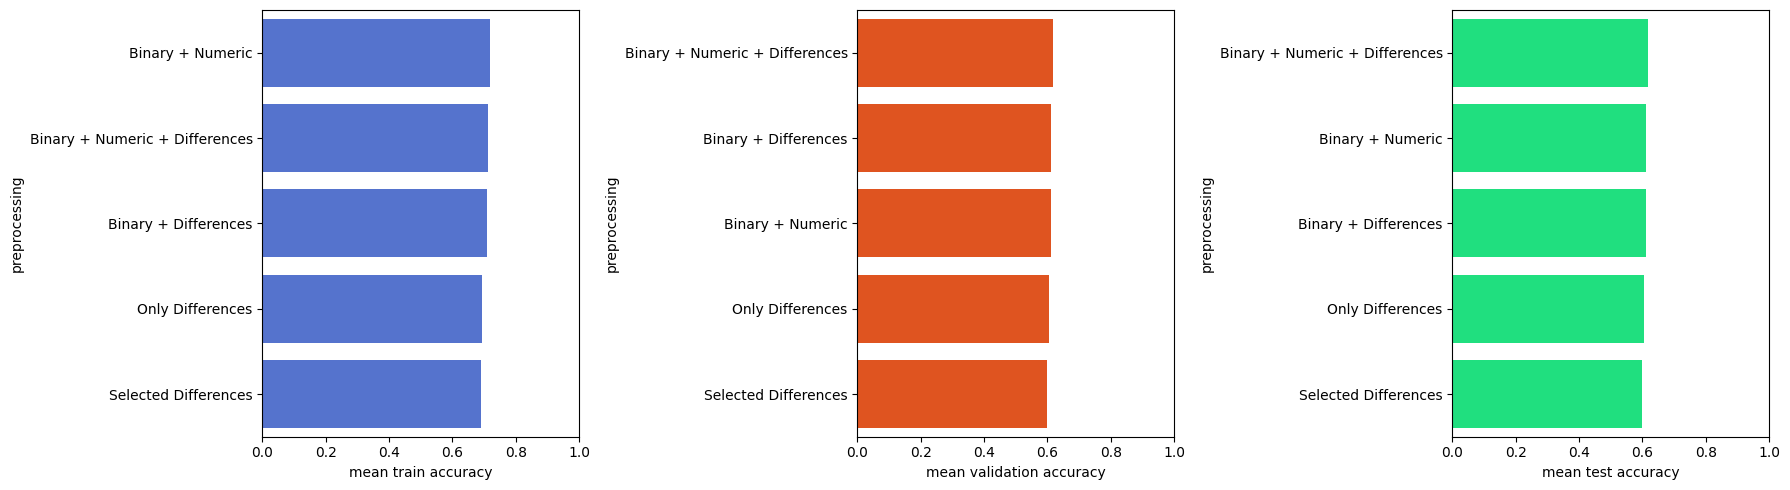

In [72]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=pd.Series(results_by_preprocessing["train_accuracy"], index=results_by_preprocessing.index).sort_values(ascending=False), orient="h", color="royalblue").set_xlabel("mean train accuracy")
plt.xlim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(data=pd.Series(results_by_preprocessing["val_accuracy"], index=results_by_preprocessing.index).sort_values(ascending=False), orient="h", color="orangered").set_xlabel("mean validation accuracy")
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
sns.barplot(data=pd.Series(results_by_preprocessing["test_accuracy"], index=results_by_preprocessing.index).sort_values(ascending=False), orient="h", color="springgreen").set_xlabel("mean test accuracy")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

Vemos que la diferencia en el rendimiento medio es muy reducida, aunque tendemos a obtener mejores resultados cuando conservamos más características.

Estudiamos ahora el rendimiento medio para cada algoritmo, destacando varios puntos para cada gráfico:

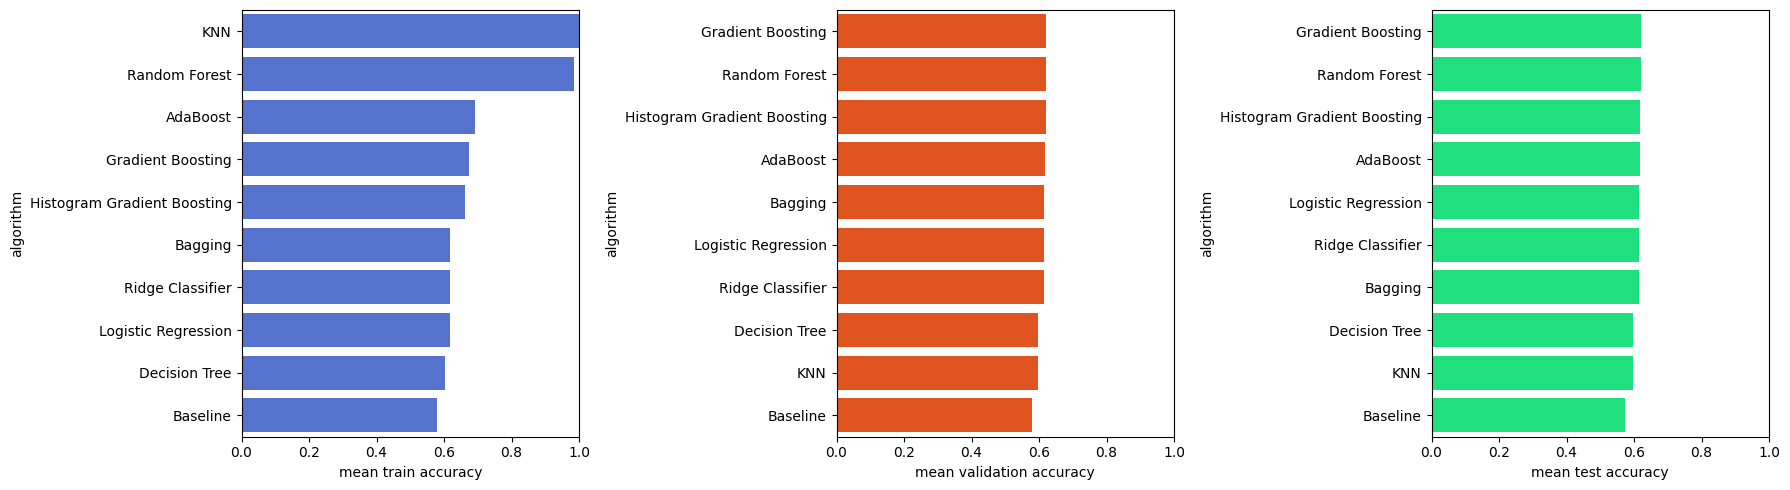

In [73]:
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=pd.Series(results_by_algorithm["train_accuracy"], index=results_by_algorithm.index).sort_values(ascending=False), orient="h", color="royalblue").set_xlabel("mean train accuracy")
plt.xlim(0, 1)

plt.subplot(1, 3, 2)
sns.barplot(data=pd.Series(results_by_algorithm["val_accuracy"], index=results_by_algorithm.index).sort_values(ascending=False), orient="h", color="orangered").set_xlabel("mean validation accuracy")
plt.xlim(0, 1)

plt.subplot(1, 3, 3)
sns.barplot(data=pd.Series(results_by_algorithm["test_accuracy"], index=results_by_algorithm.index).sort_values(ascending=False), orient="h", color="springgreen").set_xlabel("mean test accuracy")
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

Sobre el conjunto de entrenamiento:
* Los modelos que más se ajustan a los datos son *KNN* (que realmente no aprende de ellos) y *Random Forest* (las mejores configuraciones utilizaban árboles sin límite profundidad).
* Los ensembles de *Boosting* ofrecen resultados similares entre sí.
* Los árboles de decisión no se ajustan tanto a los datos porque las mejores configuraciones no eran árboles profundos.
* Los árboles de profundidad 1 utilizados como base son capaces de explicar cerca del 58% de los datos de entrenamiento.

Tras validar con una `10x5-CV`:
* *Random Forest* sobreajusta.
* La diferencia en el rendimiento entre algoritmos es muy pequeña, aunque el orden es similar (a excepción de *KNN*, que es basado en instancias y simplemente memoriza los datos de *train*).
* Los ensembles están ligeramente por encima de los clasificadores individuales.
* Tampoco existe una gran diferencia respecto a los modelos base, lo que nos indica que estamos ante un problema complejo con un margen de mejora bastante reducido (al menos con los datos actuales).

Sobre el conjunto de prueba:
* Los resultados son muy similares a los obtenidos mediante la validación.

Para elegir el modelo más adecuado, tendremos en cuenta diferentes factores:
* Rendimiento sobre validación
* Sobreajuste
* Complejidad del modelo
* Complejidad del *pipeline* de preprocesamiento

Los candidatos finales serán los 5 más eficientes sobre validación.

In [74]:
final_results.head()

,train_accuracy,val_accuracy,test_accuracy
model,,,
Random Forest (Binary + Numeric + Differences),0.994978,0.630036,0.630965
Gradient Boosting (Binary + Numeric + Differences),0.654525,0.629686,0.628503
Histogram Gradient Boosting (Binary + Numeric + Differences),0.672628,0.629631,0.628980
AdaBoost (Binary + Numeric + Differences),0.711475,0.628916,0.625724
Gradient Boosting (Binary + Numeric),0.719475,0.628160,0.630171


Entre ellos finalmente nos quedaremos con `Gradient Boosting (Binary + Numeric + Differences)` por los siguientes motivos:

* Menor sobreajuste que otros modelos, la métrica es muy estable.
    * En el caso del *Random Forest*, el sobreajuste es excesivo y el modelo no es fiable.
    * *AdaBoost* y *Histogram Gradient Boosting* son ligeramente más propensos al sobreajuste, sin ventaja clara.
* Alta eficiencia computacional
* Menor complejidad, ideal para integrarlo en la aplicación.
* Robustez ante nuevos datos: los resultados sugieren buena generalización.

In [106]:
model = models["Gradient Boosting (Binary + Numeric + Differences)"]

Vamos a mostrar la matriz de confusión y otras métricas sobre el conjunto de prueba para evaluar más profundamente su rendimiento. Tomaremos `player2` como la "clase positiva".

In [88]:
def evaluate(model, X_test, y_test, threshold=0.5):
    labels = ["player1", "player2"]
    y_proba = model.predict_proba(X_test)[:, 1]
    y_test_bin = (y_test == "player2").astype(int)
    y_pred_bin = (y_proba >= threshold).astype(int)
    y_pred_labels = np.array(labels)[y_pred_bin]

    print(f"Accuracy: {accuracy_score(y_test_bin, y_pred_bin):.4f}")
    print(f"Precision: {precision_score(y_test_bin, y_pred_bin):.4f}")
    print(f"Recall: {recall_score(y_test_bin, y_pred_bin):.4f}")
    print(f"F1 Score: {f1_score(y_test_bin, y_pred_bin):.4f}")

    _, ax = plt.subplots(1, 2, figsize=(12, 5))
    cm = confusion_matrix(y_test, y_pred_labels, labels=labels)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(cmap="Blues", ax=ax[0])
    RocCurveDisplay.from_predictions(y_test_bin, y_proba, name="ROC Curve", ax=ax[1])
    plt.tight_layout()
    plt.show()

Accuracy: 0.6285
Precision: 0.6149
Recall: 0.6873
F1 Score: 0.6491


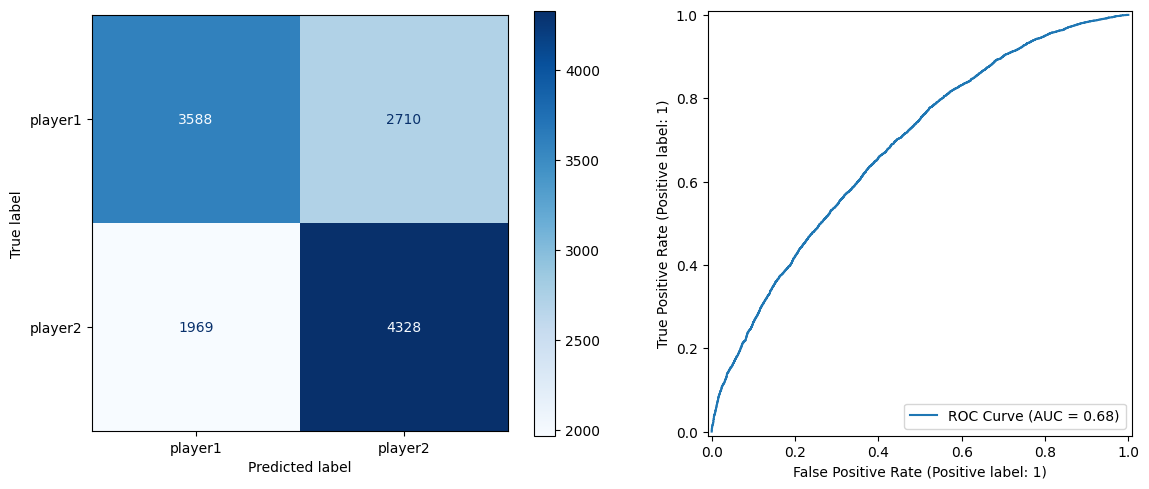

In [107]:
evaluate(model, X_test, y_test)

Vemos que, a pesar de partir de un conjunto completamente balanceado, el modelo predice que gana el segundo jugador en algunos casos más por los patrones que ha aprendido. Hemos tomado `player2` como la clase positiva, por lo que podemos ver que *recall* es más alto que otras métricas (como el modelo clasifica algunos casos más así, hay menos falsos negativos). Esto también hace que el número de falsos positivos crezca, pero hay tantos verdaderos positivos que *precision* no disminuye drásticamente. El área bajo la curva ROC no depende del umbral y es cercana al 70%.

Como encontramos algo de dificultad para clasificar como `player2`, podemos variar ligeramente el umbral de clasificación para aquellos casos de uso en los que queramos predecir únicamente el ganador y no las probabilidades de cada uno:

Accuracy: 0.6284
Precision: 0.6264
Recall: 0.6362
F1 Score: 0.6313


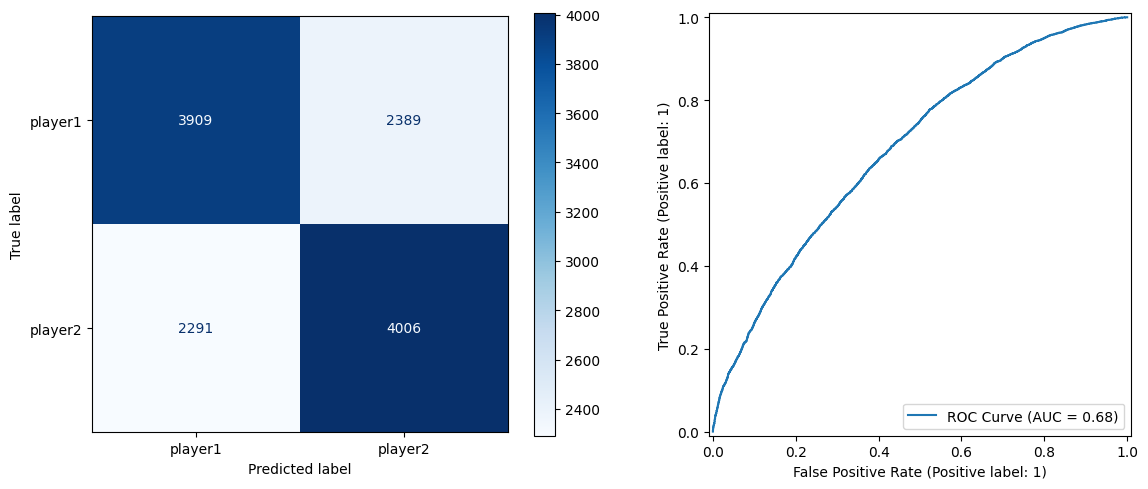

In [108]:
evaluate(model, X_test, y_test, threshold=0.52)

Esto nos permite obtener un número de predicciones más cercano entre ambos jugadores. De igual manera, hay menos diferencia entre falsos positivos y falsos negativos. Podemos ver que *precision* mejora ligeramente, aunque *recall* y *F1-score* disminuyen. El área bajo la curva ROC se mantiene, ya que no depende del umbral.

Un pequeño cambio en el umbral de clasificación ha provocado cambios considerables en los resultados, lo que nos indica que existe un porcentaje de partidas con probabilidades muy similares para ambos jugadores. Vamos a calcular las diferencias de probabilidad en valor absoluto y a describir la serie para sacar conclusiones:

In [109]:
y_proba = model.predict_proba(X_test)
diffs = np.abs(y_proba[:, 1] - y_proba[:, 0])
pd.Series(diffs).describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).to_frame().T

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
0,12595.0,0.243361,0.180551,0.000034,0.003545,0.019344,0.039297,0.098267,0.203618,0.355859,0.517325,0.603603,0.71686,0.89558


Vemos que la diferencia es menor al 4% en 1 de cada 10 partidas del conjunto de prueba (el 10% de las predicciones están más ajustadas que un [0.48, 0.52] o viceversa). Esta nunca alcanza el 90%, y es menor que el 72% en el 99% de los casos. La media es 0.24 y la mediana 0.20, lo que indica que en la mitad de los casos se obtienen probabilidades más ajustadas que un [0.4, 0.6] o viceversa. Esto nos da a entender que en este caso existe bastante incertidumbre en la predicción y que las clases están muy equilibradas por lo que es complejo encontrar patrones claros en los datos. El rendimiento obtenido y la cercanía en las probabilidades son señales de que nos encontramos ante un problema difícil de resolver, al menos cuando solamente utilizamos la información de los mazos. Esto tiene sentido, ya que todos los casos de nuestro conjunto de datos surgen de un emparejamiento dentro del juego para enfrentar a dos jugadores que a priori disputarán una partida empatada sin un claro ganador antes de comenzar.

Finalmente, guardamos el modelo seleccionado:

In [110]:
joblib.dump(model, "../pipelines/models/model.joblib");

---

<a id="section5"></a>
## <font color="#00586D"> 5. Conclusiones</font>

Durante esta fase hemos probado una gran cantidad de modelos (+1300), combinando múltiples algoritmos de aprendizaje de distinta complejidad con nuestros *pipelines* de preprocesamiento implementados en la fase anterior.
* Se han utilizado árboles de profundidad 1 como *baselines* para comparar los resultados y estudiar el margen de mejora respecto a un clasificador extremadamente sencillo para los diferentes *pipelines*.
* Se han optimizado los hiperparámetros de los modelos mediante validación cruzada con `GridSearchCV`, seleccionando las mejores configuraciones y reentrenando estos modelos con todos los datos de entrenamiento.
* Estos candidatos se han vuelto a validar durante la evaluación final utilizando una validación cruzada más robusta para obtener una estimación aún más honesta del rendimiento.
* Se ha evaluado también el rendimiento sobre el propio conjunto de entrenamiento y sobre el conjunto de prueba que habíamos reservado.
* Se han tomado decisiones en base a diferentes factores como el sobreajuste, la complejidad del modelo, etc.

Respecto a los resultados, podemos concluir lo siguiente:

* Nos encontramos ante un problema complejo, en que el hemos logrado alcanzar una tasa de acierto alrededor del 63% sobre validación y *test* sin un gran margen de mejora respecto a los *baselines*.
* Las variables más importantes parecen ser las relacionadas con los niveles.
* Los ensembles han ofrecido mejores resultados, aunque la diferencia con los clasificadores individuales es muy reducida. Sorprende que los modelos lineales hayan tenido un rendimiento tan cercano a ellos.
* Se ha producido sobreajuste en algunos casos, aunque para *Random Forest* ha sido excesivo.
* Existe mucha incertidumbre en las predicciones, cuyas probabilidades son cercanas para una gran cantidad de ejemplos del conjunto de prueba.
* Si no trabajamos con probabilidades cuando utilicemos el modelo, podemos incrementar ligeramente el umbral de clasificación para nivelar el número de aciertos por jugador (sobre *test* se predice algo más el segundo jugador).

La principal conclusión que sacamos tras esta primera aproximación es que el sistema de *matchmaking* del juego es correcto, ya que todas las partidas con las que hemos trabajado representan un enfrentamiento entre dos jugadores emparejados por el juego que a priori no debe tener un ganador claro. La incertidumbre y la dificultad para encontrar patrones sólidos puede deberse a que hay tantos factores a tener en cuenta que al final la partida termina nivelándose. Si hubiéramos logrado obtener un mejor modelo, esto podría llegar a significar que este sistema no está tan bien hecho.

Algunas mejoras de cara al futuro para experimentar mejoras son:
* Introducir nuevas variantes en el preprocesamiento (discretización, combinación de las variables binarias, creación de otras características, escalado sensible a valores extremos...)
* Aumentar el tamaño del conjunto de datos de entrenamiento. Esto podría hacer que las variables comunes a ambos jugadores tuvieran un comportamiento más parecido entre ellas y las diferencias ganaran importancia.
* Complementar la información de los mazos con otros datos sobre los jugadores (nivel de experiencia, récord de trofeos, tasa de victorias, maestría de las cartas utilizadas, etc.). Esta opción se planteó al inicio del proyecto, pero no se llevó a cabo porque existe un desfase temporal entre el momento en el que se jugó la partida y el perfil actual de los jugadores obtenido a través de la API. Para ello, sería necesario asumir un margen de error o implementar un sistema que recopile la información en tiempo real.

---